In [949]:
#k最近傍法（2018年12月〜2019年6月中旬までの糖度を予測）

In [950]:
%matplotlib inline
import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [951]:
# データの読み込み
data = pd.read_csv("../src/Aiko_normalization_ver3_aaa.csv")
df = pd.DataFrame(data)

In [952]:
df.drop(['No','width','height','seed_date','house','url', 'COL_21'], axis=1, inplace=True) #対象の列を削除

In [953]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 14 columns):
current_date      2176 non-null object
sweet             2176 non-null float64
sweet_category    2176 non-null int64
size              2176 non-null float64
AveCO2_7          2176 non-null float64
AveSatu_7         2176 non-null float64
AveHum_7          2176 non-null float64
AveTemp_7         2176 non-null float64
AveMaxTemp_7      2176 non-null float64
AveMinTemp_7      2176 non-null float64
AveDiffTemp_7     2176 non-null float64
SumMaxTemp_7      2176 non-null float64
SumMinTemp_7      2176 non-null float64
SumDiffTemp_7     2176 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 238.1+ KB


In [954]:
# AveDiffTemp_7、AveSatu_7、monthを対象としたい時
#df.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveHum_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'], axis=1, inplace=True)

In [955]:
df.head()

,current_date,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
0,11月28日,4.3,2,7.54,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
1,11月28日,4.5,2,6.48,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
2,11月28日,4.0,1,8.68,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
3,11月28日,3.5,1,10.50,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
4,11月28日,4.3,2,7.00,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9


In [956]:
# 'AveCO2_7', 'AveSatu_7', 'AveHum_7', 'AveTemp_7', 'AveMaxTemp_7', 'AveMinTemp_7','AveDiffTemp_7','SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'

In [957]:
#df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
#df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する

#df['month'].isnull().sum() # 欠損値がないかを確認

#df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
#print(df.shape)
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html

In [958]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
#df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
#                                     '7': '2nd', '8': '2nd', '9': '2nd', 
#                                     '10': '3rd', '11': '3rd', '12': '3rd', 
#                                     '1': '4th', '2': '4th', '3': '4th'
#                                    })

In [959]:
# ダミー変数の作成
#df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [960]:
#df.drop(['month'], axis=1, inplace=True)

In [961]:
df.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000
mean,4.689890,2.776654,6.568267,534.566678,7.531237,62.433931,21.766846,27.484560,17.887496,9.595469,192.386765,125.213529,67.173456
std,0.530061,0.977789,1.830271,100.540048,1.402898,3.964303,1.362018,2.714338,1.485614,3.226052,19.002837,10.400903,22.577841
min,3.000000,1.000000,2.560000,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.300000,2.000000,5.250000,443.180000,6.400000,59.690000,20.760000,25.890000,17.770000,7.740000,181.200000,124.400000,54.200000
50%,4.700000,3.000000,6.440000,504.820000,7.370000,61.330000,21.390000,26.240000,18.210000,8.160000,183.700000,127.500000,57.100000
75%,5.100000,4.000000,7.800000,622.340000,8.075000,66.270000,22.410000,29.060000,18.670000,12.250000,203.400000,130.700000,85.750000
max,6.000000,4.000000,14.000000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [962]:
df.corr()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
sweet,1.000000,0.948026,-0.845930,0.149696,-0.102477,-0.086414,-0.231788,-0.256549,0.087282,-0.256248,-0.256605,0.087076,-0.256092
sweet_category,0.948026,1.000000,-0.845716,0.147071,-0.095435,-0.092968,-0.227828,-0.250357,0.088490,-0.251585,-0.250397,0.088279,-0.251422
size,-0.845930,-0.845716,1.000000,-0.316388,0.270745,-0.005937,0.417896,0.411442,-0.165116,0.422383,0.411474,-0.164920,0.422303
AveCO2_7,0.149696,0.147071,-0.316388,1.000000,-0.655139,0.406979,-0.700366,-0.647394,0.195133,-0.634566,-0.647212,0.195217,-0.634670
AveSatu_7,-0.102477,-0.095435,0.270745,-0.655139,1.000000,-0.795076,0.876089,0.728993,0.004405,0.611319,0.728858,0.004476,0.611402
AveHum_7,-0.086414,-0.092968,-0.005937,0.406979,-0.795076,1.000000,-0.438052,-0.204585,-0.020980,-0.162219,-0.204393,-0.021014,-0.162364
AveTemp_7,-0.231788,-0.227828,0.417896,-0.700366,0.876089,-0.438052,1.000000,0.875936,-0.003704,0.738866,0.875861,-0.003649,0.738867
AveMaxTemp_7,-0.256549,-0.250357,0.411442,-0.647394,0.728993,-0.204585,0.875936,1.000000,-0.102683,0.888889,1.000000,-0.102540,0.888901
AveMinTemp_7,0.087282,0.088490,-0.165116,0.195133,0.004405,-0.020980,-0.003704,-0.102683,1.000000,-0.546973,-0.102467,0.999998,-0.546952
AveDiffTemp_7,-0.256248,-0.251585,0.422383,-0.634566,0.611319,-0.162219,0.738866,0.888889,-0.546973,1.000000,0.888790,-0.546853,1.000000


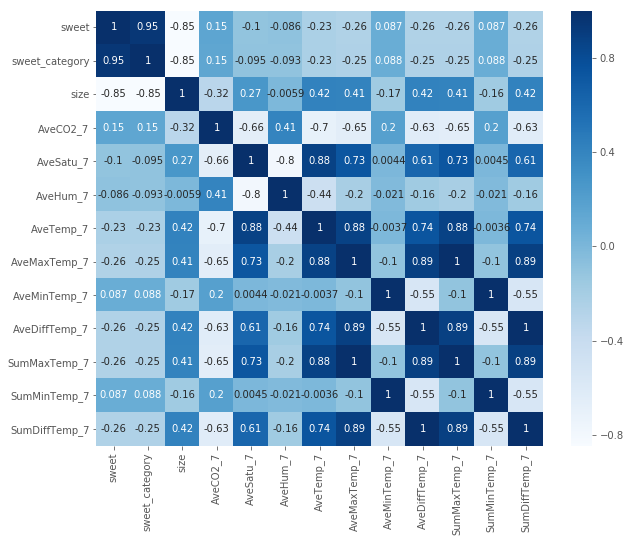

In [963]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

In [964]:
df['size'] = df['size']**2

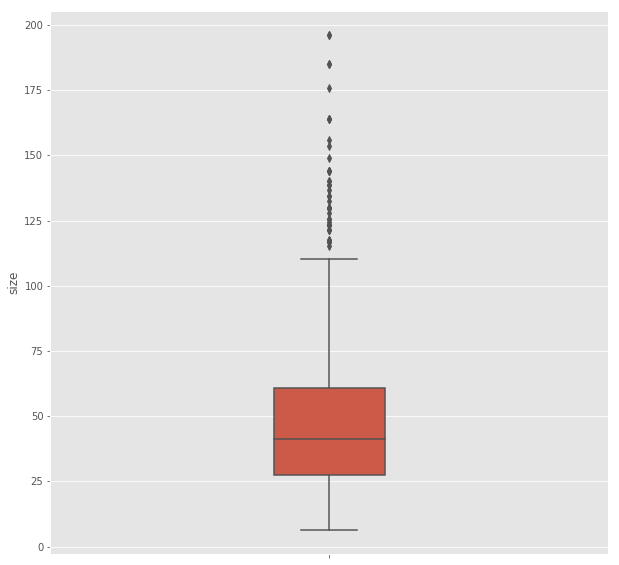

In [965]:
plt.figure(figsize=(10, 10))
sns.boxplot(df['size'], orient='v', width=0.2)

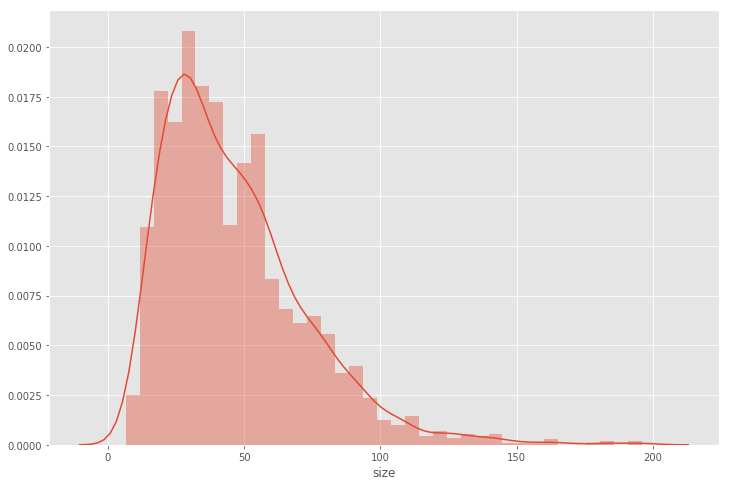

In [966]:
plt.figure(figsize=(12, 8))
sns.distplot(df['size'])

In [967]:
print(df.columns)

Index(['current_date', 'sweet', 'sweet_category', 'size', 'AveCO2_7',
       'AveSatu_7', 'AveHum_7', 'AveTemp_7', 'AveMaxTemp_7', 'AveMinTemp_7',
       'AveDiffTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'SumDiffTemp_7'],
      dtype='object')


In [968]:
df.shape

(2176, 14)

In [969]:
# sweet_categoryが1のものについて
df_1 = df[(df['sweet_category'] == 1)]

In [970]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 2 to 2164
Data columns (total 14 columns):
current_date      257 non-null object
sweet             257 non-null float64
sweet_category    257 non-null int64
size              257 non-null float64
AveCO2_7          257 non-null float64
AveSatu_7         257 non-null float64
AveHum_7          257 non-null float64
AveTemp_7         257 non-null float64
AveMaxTemp_7      257 non-null float64
AveMinTemp_7      257 non-null float64
AveDiffTemp_7     257 non-null float64
SumMaxTemp_7      257 non-null float64
SumMinTemp_7      257 non-null float64
SumDiffTemp_7     257 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 30.1+ KB


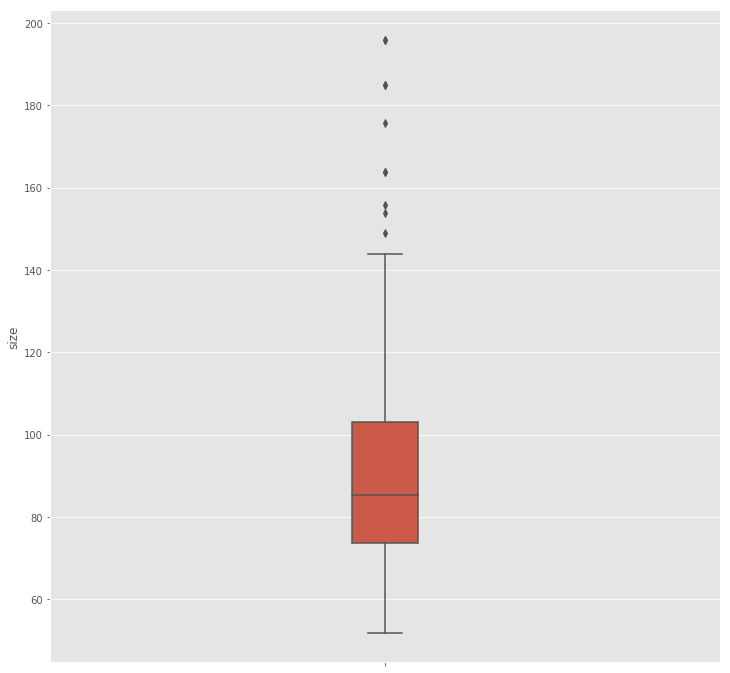

In [971]:
plt.figure(figsize=(12, 12))
sns.boxplot(df_1['size'], orient='v', width=0.1)

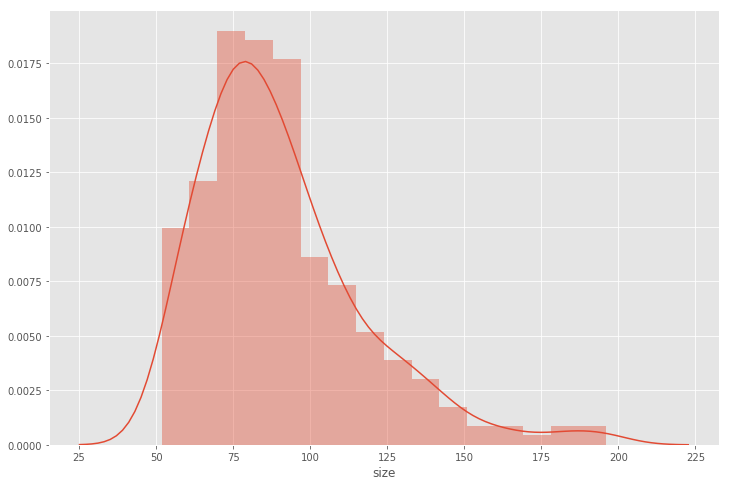

In [972]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1['size'])

In [973]:
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        # 四分位範囲
        iqr = q3 - q1
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5
        # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
    return df

In [974]:
print("before", df_1.shape)
df_1 = outlier_iqr(df_1, ['size'])
print("after", df_1.shape)

before (257, 14)
after (247, 14)


In [975]:
#対数をとって正規分布にする
#df['size'] = np.log1p(df['size'])
#df['size'].head()

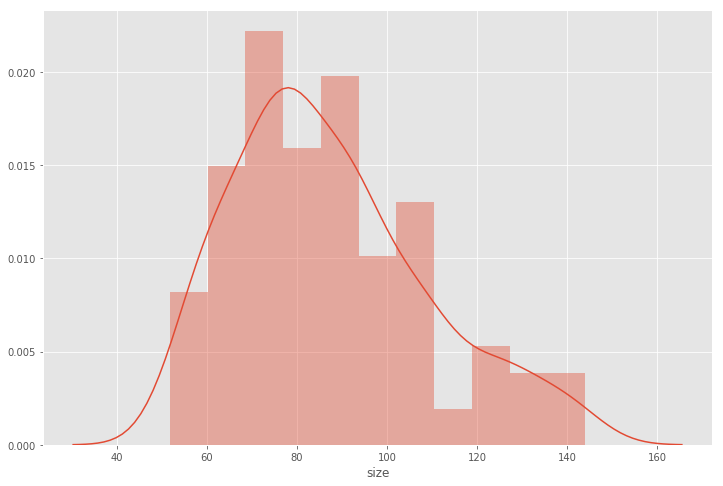

In [976]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1['size'])

In [977]:
# sweet_categoryが2のものについて
df_2 = df[(df['sweet_category'] == 2)]

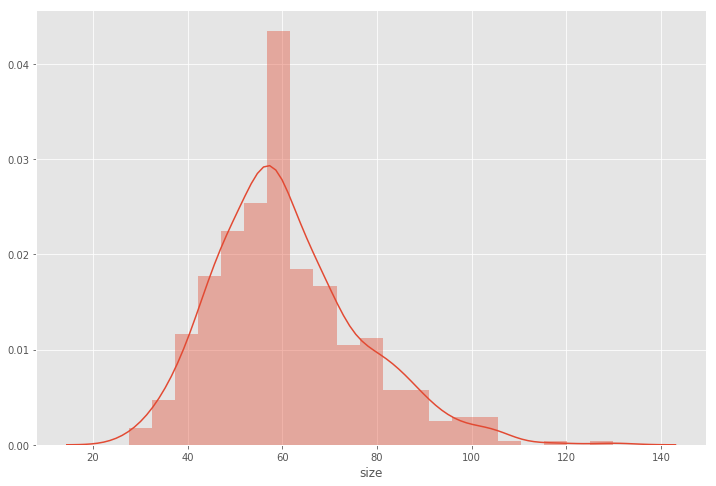

In [978]:
plt.figure(figsize=(12, 8))
sns.distplot(df_2['size'])

In [979]:
print("before", df_2.shape)
df_2 = outlier_iqr(df_2, ['size'])
print("after", df_2.shape)

before (566, 14)
after (555, 14)


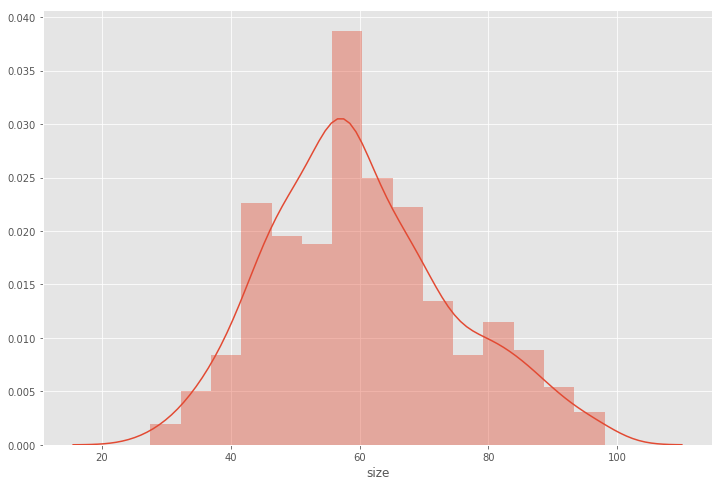

In [980]:
plt.figure(figsize=(12, 8))
sns.distplot(df_2['size'])

In [981]:
# sweet_categoryが3のものについて
df_3 = df[(df['sweet_category'] == 3)]

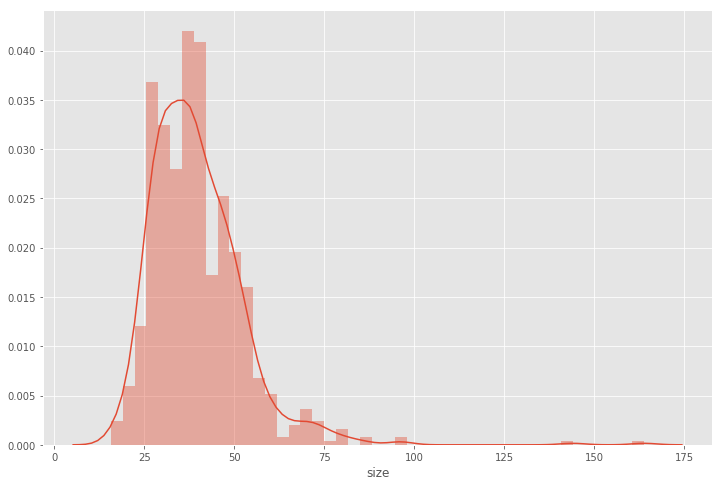

In [982]:
plt.figure(figsize=(12, 8))
sns.distplot(df_3['size'])

In [983]:
print("before", df_3.shape)
df_3 = outlier_iqr(df_3, ['size'])
print("after", df_3.shape)

before (759, 14)
after (733, 14)


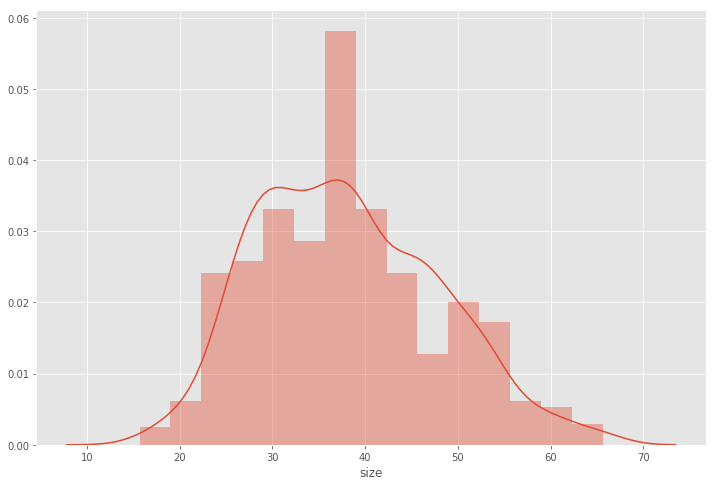

In [984]:
plt.figure(figsize=(12, 8))
sns.distplot(df_3['size'])

In [985]:
# sweet_categoryが2のものについて
df_4 = df[(df['sweet_category'] == 4)]

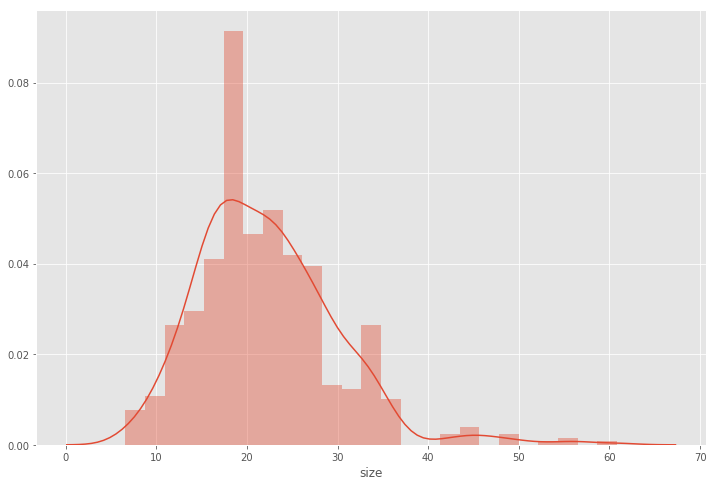

In [986]:
plt.figure(figsize=(12, 8))
sns.distplot(df_4['size'])

In [987]:
print("before", df_4.shape)
df_4 = outlier_iqr(df_4, ['size'])
print("after", df_4.shape)

before (594, 14)
after (579, 14)


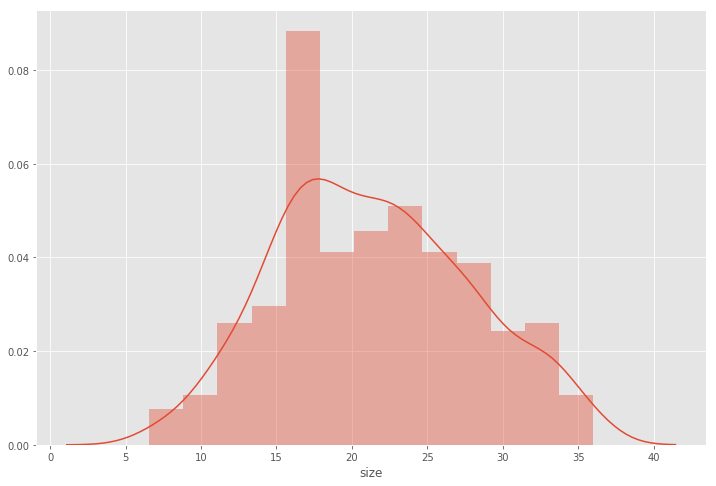

In [988]:
plt.figure(figsize=(12, 8))
sns.distplot(df_4['size'])

In [989]:
# df_1について
df_1.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,247.000000,247.0,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,3.763563,1.0,87.433311,528.269579,7.635249,63.145029,22.143471,28.242007,17.894748,10.346935,197.691498,125.267895,72.423968
std,0.233322,0.0,21.592202,113.836500,1.494770,4.413807,1.342267,2.876826,1.705911,3.430226,20.138633,11.944822,24.012275
min,3.000000,1.0,51.840000,400.770000,5.800000,55.930000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,3.700000,1.0,73.616400,440.260000,6.080000,58.980000,20.810000,26.200000,17.610000,7.900000,183.400000,123.250000,55.300000
50%,3.800000,1.0,84.272400,480.530000,7.380000,63.830000,22.340000,26.890000,18.270000,8.540000,188.200000,127.900000,59.800000
75%,3.900000,1.0,101.606400,622.340000,9.040000,67.155000,23.385000,30.170000,18.970000,13.470000,211.200000,132.800000,94.300000
max,4.000000,1.0,144.000000,760.640000,10.830000,70.810000,25.340000,33.840000,19.570000,17.500000,236.900000,137.000000,122.480000


In [990]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa1_a = df_1.query('size >= 63 & size < 73 & index % 2 == 0')

In [991]:
# indexのリスト
indexes = df_exa1_a.index.values
print(indexes)

[  64  122  142  148  258  746  800  812 1436 1520 1592 1608 1614 1780
 1810]


In [992]:
# df_1の大きさを確認
df_1['size'].size

247

In [993]:
# df_1から、該当する行を削除
df_1 = df_1.drop(indexes)

In [994]:
# df_1の行数が減ったことを確認
df_1['size'].size

232

In [995]:
# 抽出したデータの大きさを確認
exa1_a_count = df_exa1_a['size'].size

In [996]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(80, 100) for i in range(exa1_a_count)]

In [997]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa1_a['size'] = rand_list

In [998]:
# 書き換わっていることを確認
df_exa1_a['size']

64      90.072984
122     91.944151
142     95.437793
148     87.016472
258     87.086193
746     82.836555
800     85.655433
812     97.820094
1436    94.199508
1520    87.168715
1592    98.376605
1608    95.422312
1614    94.690531
1780    92.279641
1810    95.455098
Name: size, dtype: float64

In [999]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa1_b = df_1.query('size >= 51 & size < 63 & index % 2 == 0')

In [1000]:
# indexのリスト
indexes = df_exa1_b.index.values
print(indexes)

[  52   76  144  198  238  288  390  686  720  784  794  814 1432 1666
 1818]


In [1001]:
# df_1の大きさを確認
df_1['size'].size

232

In [1002]:
# df_1から、該当する行を削除
df_1 = df_1.drop(indexes)

In [1003]:
# df_1の大きさを確認
df_1['size'].size

217

In [1004]:
# 抽出したデータの大きさを確認
exa1_b_count = df_exa1_b['size'].size

In [1005]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(90, 110) for i in range(exa1_b_count)]

In [1006]:
# <-----------------------------------------------------------------------
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa1_b['size'] = rand_list

In [1007]:
# 書き換わっていることを確認
df_exa1_b['size']

52      100.341620
76      105.828097
144      94.627968
198     104.308682
238      95.582624
288      98.775707
390      95.807915
686      93.950486
720      95.908441
784      98.152567
794     103.530549
814     102.640097
1432    102.824592
1666    105.061588
1818    107.167181
Name: size, dtype: float64

In [1008]:
# 3つのデータフレームを結合
df_1_new = pd.concat([df_1, df_exa1_a, df_exa1_b])

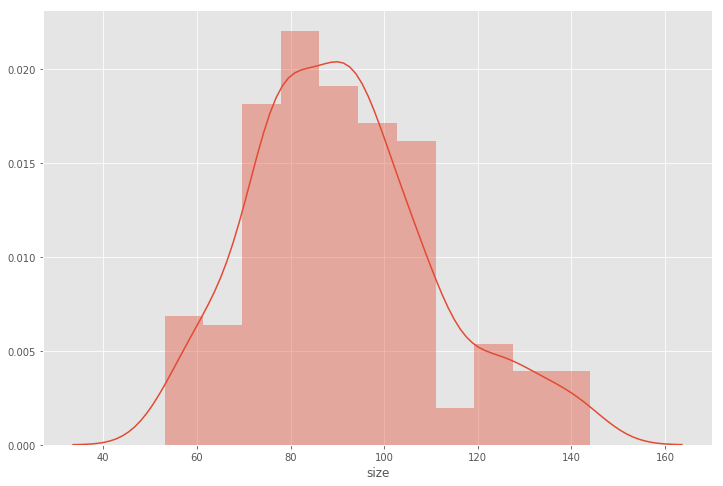

In [1009]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1_new['size'])

In [1010]:
# 前処理後のカテゴリ1の基本統計量
df_1_new.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,247.000000,247.0,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,3.763563,1.0,91.430816,528.269579,7.635249,63.145029,22.143471,28.242007,17.894748,10.346935,197.691498,125.267895,72.423968
std,0.233322,0.0,19.688695,113.836500,1.494770,4.413807,1.342267,2.876826,1.705911,3.430226,20.138633,11.944822,24.012275
min,3.000000,1.0,53.144100,400.770000,5.800000,55.930000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,3.700000,1.0,76.562500,440.260000,6.080000,58.980000,20.810000,26.200000,17.610000,7.900000,183.400000,123.250000,55.300000
50%,3.800000,1.0,90.630400,480.530000,7.380000,63.830000,22.340000,26.890000,18.270000,8.540000,188.200000,127.900000,59.800000
75%,3.900000,1.0,103.022500,622.340000,9.040000,67.155000,23.385000,30.170000,18.970000,13.470000,211.200000,132.800000,94.300000
max,4.000000,1.0,144.000000,760.640000,10.830000,70.810000,25.340000,33.840000,19.570000,17.500000,236.900000,137.000000,122.480000


In [1011]:
# df_2について
df_2.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,555.000000,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,4.310090,2.0,60.216867,516.225209,7.612574,62.895825,22.008540,28.161755,17.650445,10.510121,197.128288,123.556216,73.572432
std,0.137431,0.0,14.162179,101.564531,1.422049,4.258914,1.362928,2.780768,1.800703,3.499934,19.466131,12.605759,24.493900
min,4.100000,2.0,27.562500,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.200000,2.0,49.280400,432.010000,6.400000,59.690000,20.950000,25.995000,17.270000,7.825000,181.950000,120.900000,54.800000
50%,4.300000,2.0,57.153600,481.180000,7.370000,61.830000,21.560000,26.660000,18.210000,8.540000,186.600000,127.500000,59.800000
75%,4.400000,2.0,69.222400,595.830000,8.800000,67.020000,23.150000,30.200000,18.790000,13.630000,211.400000,131.500000,95.400000
max,4.500000,2.0,98.010000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1012]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa2_a = df_2.query('size >= 40 & size < 49 & index % 2 == 1')

In [1013]:
# indexのリスト
indexes = df_exa2_a.index.values
print(indexes)

[   1   93  121  149  155  189  195  197  199  231  249  299  381  407
  415  601  685  687  691  697  775  895  901  929  951 1631 1667 1669
 1797 1807 1815 1817 1991 2017 2025]


In [1014]:
# df_2の大きさを確認
df_2['size'].size

555

In [1015]:
# df_2から、該当する行を削除
df_2 = df_2.drop(indexes)

In [1016]:
# df_2の大きさを確認
df_2['size'].size

520

In [1017]:
# 抽出したデータの大きさを確認
exa2_a_count = df_exa2_a['size'].size

In [1018]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(50, 65) for i in range(exa2_a_count)]

In [1019]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa2_a['size'] = rand_list

In [1020]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa2_b = df_2.query('size >= 27 & size < 40 & index % 2 == 0')

In [1021]:
df_exa2_b['size'].size

20

In [1022]:
# indexのリスト
indexes = df_exa2_b.index.values
print(indexes)

[  10  104  118  130  496  608  646  662  690  740  858 1470 1504 1508
 1514 1636 1642 1646 1806 1852]


In [1023]:
# df_2の大きさを確認
df_2['size'].size

# df_1から、該当する行を削除
df_2 = df_2.drop(indexes)

# df_2の大きさを確認
df_2['size'].size

500

In [1024]:
# 抽出したデータの大きさを確認
exa2_b_count = df_exa2_b['size'].size

# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(47, 55) for i in range(exa2_b_count)]

In [1025]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa2_b['size'] = rand_list

In [1026]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa2_c = df_2.query('size >= 70 & size < 85 & index % 2 == 1')
df_exa2_c['size'].size

49

In [1027]:
# indexのリスト
indexes = df_exa2_c.index.values
print(indexes)

[  23   47  955  995 1033 1053 1065 1091 1093 1103 1161 1179 1201 1403
 1405 1433 1447 1457 1559 1593 1605 1679 1691 1707 1829 1879 1881 1889
 1901 1907 1959 1987 2001 2013 2039 2055 2059 2083 2113 2115 2137 2139
 2141 2145 2153 2159 2167 2171 2175]


In [1028]:
# df_2の大きさを確認
print(df_2['size'].size)

# df_1から、該当する行を削除
df_2 = df_2.drop(indexes)

# df_2の大きさを確認
print(df_2['size'].size)

500
451


In [1029]:
# 抽出したデータの大きさを確認
exa2_c_count = df_exa2_c['size'].size

# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(55, 70) for i in range(exa2_c_count)]

In [1030]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa2_c['size'] = rand_list

In [1031]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa2_d = df_2.query('size >= 85 & size < 99 & index % 2 == 1')
df_exa2_d['size'].size

25

In [1032]:
# indexのリスト
indexes = df_exa2_d.index.values
print(indexes)

[  39  967 1531 1551 1565 1681 1685 1687 1689 1701 1711 1715 1721 1729
 1759 1857 1865 1899 1927 1929 1941 1957 2111 2119 2133]


In [1033]:
# df_2の大きさを確認
print(df_2['size'].size)

# df_1から、該当する行を削除
df_2 = df_2.drop(indexes)

# df_2の大きさを確認
print(df_2['size'].size)

451
426


In [1034]:
# 抽出したデータの大きさを確認
exa2_d_count = df_exa2_d['size'].size

# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(65, 75) for i in range(exa2_d_count)]

In [1035]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa2_d['size'] = rand_list

In [1036]:
# <-----------------------------------------------------------------------
# 4つのデータフレームを結合
df_2_new = pd.concat([df_2, df_exa2_a, df_exa2_b, df_exa2_c, df_exa2_d])

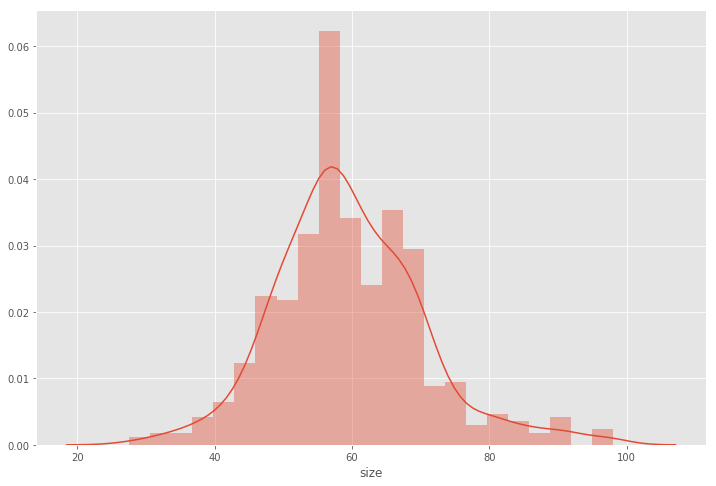

In [1037]:
plt.figure(figsize=(12, 8))
sns.distplot(df_2_new['size'])

In [1038]:
# 前処理後のカテゴリ2の基本統計量
df_2_new.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,555.000000,555.0,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,4.310090,2.0,59.568227,516.225209,7.612574,62.895825,22.008540,28.161755,17.650445,10.510121,197.128288,123.556216,73.572432
std,0.137431,0.0,10.762985,101.564531,1.422049,4.258914,1.362928,2.780768,1.800703,3.499934,19.466131,12.605759,24.493900
min,4.100000,2.0,27.562500,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.200000,2.0,52.562500,432.010000,6.400000,59.690000,20.950000,25.995000,17.270000,7.825000,181.950000,120.900000,54.800000
50%,4.300000,2.0,57.153600,481.180000,7.370000,61.830000,21.560000,26.660000,18.210000,8.540000,186.600000,127.500000,59.800000
75%,4.400000,2.0,65.610000,595.830000,8.800000,67.020000,23.150000,30.200000,18.790000,13.630000,211.400000,131.500000,95.400000
max,4.500000,2.0,98.010000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1039]:
# df_3について
df_3.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,733.000000,733.0,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,4.794952,3.0,38.120183,535.957134,7.432305,62.432810,21.637907,27.190553,17.805093,9.383674,190.327285,124.635730,65.691733
std,0.139727,0.0,9.803869,98.040378,1.211224,3.907555,1.179989,2.390497,1.453463,3.127669,16.733906,10.177768,21.888723
min,4.600000,3.0,15.681600,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.700000,3.0,30.470400,457.770000,6.430000,59.690000,20.760000,25.890000,17.660000,7.557143,181.200000,123.600000,52.900000
50%,4.800000,3.0,37.945600,504.820000,7.370000,61.330000,21.260000,26.210000,18.140000,8.070000,183.500000,127.000000,56.500000
75%,4.900000,3.0,45.562500,622.340000,8.050000,66.270000,22.340000,29.060000,18.570000,11.140000,203.400000,130.000000,78.000000
max,5.000000,3.0,65.610000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1040]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa3_a = df_3.query('size >= 20 & size < 30 & index % 2 == 0')

In [1041]:
# indexのリスト
indexes = df_exa3_a.index.values
print(indexes)

[  12   14   16   26   70   92   94  106  110  112  116  158  170  176
  250  266  276  294  314  328  338  340  342  400  402  462  536  570
  578  580  582  616  648  656  664  668  708  718  764  766  776  852
  868  884  906  942  948  964  974  998 1030 1132 1152 1154 1164 1216
 1228 1354 1374 1442 1472 1482 1484 1486 1506 1650 1654 1754 1838 1842
 2076 2086]


In [1042]:
# df_3の大きさを確認
df_3['size'].size

733

In [1043]:
# df_3から、該当する行を削除
df_3 = df_3.drop(indexes)

In [1044]:
# df_3の大きさを確認
df_3['size'].size

661

In [1045]:
# 抽出したデータの大きさを確認
exa3_a_count = df_exa3_a['size'].size

In [1046]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
rand_list = [random.uniform(35, 42) for i in range(exa3_a_count)]

In [1047]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa3_a['size'] = rand_list

In [1048]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa3_b = df_3.query('size >= 15 & size < 20 & index % 2 == 0')

# indexのリスト
indexes = df_exa3_b.index.values
print(indexes)

[  18   20  532  666  670  672 1512]


In [1049]:
# df_3の大きさを確認
df_3['size'].size

661

In [1050]:
# df_3から、該当する行を削除
df_3 = df_3.drop(indexes)

# df_3の大きさを確認
df_3['size'].size

654

In [1051]:
# 抽出したデータの大きさを確認
exa3_b_count = df_exa3_b['size'].size

In [1052]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(30, 35) for i in range(exa3_b_count)]

In [1053]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa3_b['size'] = rand_list

In [1054]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa3_c = df_3.query('size >= 46 & size < 60 & index % 2 == 0')

# indexのリスト
indexes = df_exa3_c.index.values
print(indexes)

[  42   46   84  200  284  344  396  820  842 1016 1026 1032 1052 1058
 1086 1088 1098 1104 1200 1230 1302 1308 1332 1338 1348 1384 1394 1422
 1426 1428 1446 1460 1528 1536 1540 1552 1556 1562 1576 1618 1626 1690
 1700 1750 1758 1764 1820 1822 1828 1912 1966 1988 2006 2046 2060 2106
 2122 2144 2160 2168 2172 2174]


In [1055]:
# df_3の大きさを確認
df_3['size'].size

654

In [1056]:
# df_3から、該当する行を削除
df_3 = df_3.drop(indexes)

# df_3の大きさを確認
df_3['size'].size

592

In [1057]:
# 抽出したデータの大きさを確認
exa3_c_count = df_exa3_c['size'].size

In [1058]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(37, 50) for i in range(exa3_c_count)]

In [1059]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa3_c['size'] = rand_list

In [1060]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa3_d = df_3.query('size >= 60 & size < 65 & index % 2 == 1')

# indexのリスト
indexes = df_exa3_d.index.values
print(indexes)

[  41 1383 1427 1555 1753 1769 1905 1909 2005 2165]


In [1061]:
# df_3の大きさを確認
df_3['size'].size

592

In [1062]:
# df_3から、該当する行を削除
df_3 = df_3.drop(indexes)

# df_3の大きさを確認
df_3['size'].size

582

In [1063]:
# 抽出したデータの大きさを確認
exa3_d_count = df_exa3_d['size'].size

In [1064]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(47, 55) for i in range(exa3_d_count)]

# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa3_d['size'] = rand_list

In [1065]:
# <-----------------------------------------------------------------------
# 4つのデータフレームを結合
df_3_new = pd.concat([df_3, df_exa3_a, df_exa3_b, df_exa3_c, df_exa3_d])

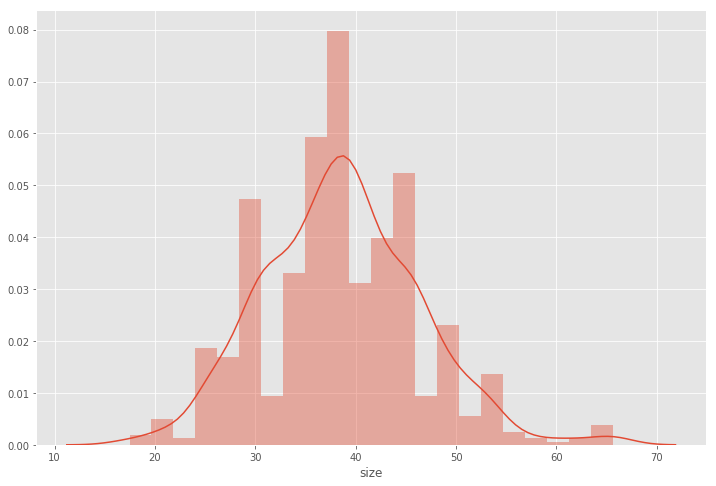

In [1066]:
plt.figure(figsize=(12, 8))
sns.distplot(df_3_new['size'])

In [1067]:
# df_3_newについて
df_3_new.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,733.000000,733.0,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,4.794952,3.0,38.607503,535.957134,7.432305,62.432810,21.637907,27.190553,17.805093,9.383674,190.327285,124.635730,65.691733
std,0.139727,0.0,7.802648,98.040378,1.211224,3.907555,1.179989,2.390497,1.453463,3.127669,16.733906,10.177768,21.888723
min,4.600000,3.0,17.472400,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.700000,3.0,33.062500,457.770000,6.430000,59.690000,20.760000,25.890000,17.660000,7.557143,181.200000,123.600000,52.900000
50%,4.800000,3.0,38.779391,504.820000,7.370000,61.330000,21.260000,26.210000,18.140000,8.070000,183.500000,127.000000,56.500000
75%,4.900000,3.0,43.318873,622.340000,8.050000,66.270000,22.340000,29.060000,18.570000,11.140000,203.400000,130.000000,78.000000
max,5.000000,3.0,65.610000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1068]:
# df_4について
df_4.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,579.000000,579.0,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,5.322280,4.0,21.469397,562.977520,7.204675,62.175214,21.203702,26.326558,18.118961,8.205231,184.278756,126.831813,57.447012
std,0.194752,0.0,6.488028,90.767345,1.056031,3.086654,0.944818,1.910062,0.836961,2.094808,13.373004,5.859029,14.659130
min,5.100000,4.0,6.553600,400.770000,5.850000,55.550000,20.301240,24.540000,11.560000,5.910000,171.800000,80.930000,41.400000
25%,5.200000,4.0,16.000000,503.050000,6.430000,61.000000,20.610000,25.860000,17.940000,7.290000,181.000000,125.600000,51.000000
50%,5.300000,4.0,21.344400,511.130000,7.170000,61.330000,20.980000,25.900000,18.110000,7.840000,181.300000,126.800000,54.900000
75%,5.400000,4.0,25.603600,637.670000,7.430000,65.030000,21.390000,26.340000,18.430000,8.200000,184.400000,129.000000,57.400000
max,6.000000,4.0,36.000000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1069]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa4_a = df_4.query('size >= 25 & size < 31 & index % 2 == 0')

# indexのリスト
indexes = df_exa4_a.index.values
print(indexes)

[  28   30  168  246  262  286  476  482  486  490  500  506  508  528
  542  544  552  556  620  762  770  796  824  832  848  850  874  914
  934  954  962  966  982  986  992 1036 1042 1048 1064 1068 1076 1082
 1100 1118 1146 1196 1238 1240 1252 1256 1258 1260 1264 1266 1276 1304
 1336 1352 1366 1382 1388 1390 1440 1488 1490 1544 1582 1590 1676 1870
 1950 1968 2066]


In [1070]:
# df_4の大きさを確認
df_4['size'].size

579

In [1071]:
# df_4から、該当する行を削除
df_4 = df_4.drop(indexes)

# df_3の大きさを確認
df_4['size'].size

506

In [1072]:
# 抽出したデータの大きさを確認
exa4_a_count = df_exa4_a['size'].size

In [1073]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(18, 22) for i in range(exa4_a_count)]

# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa4_a['size'] = rand_list

In [1074]:
# <-----------------------------------------------------------------------
# 条件にあたるデータをデータフレームから抽出
df_exa4_b = df_4.query('size >= 31 & size < 37 & index % 2 == 1')

# indexのリスト
indexes = df_exa4_b.index.values
print(indexes)

[  31   33  175  241  401  425  451  475  531  553  579  611  763  823
  853  919  927 1027 1077 1117 1567 1931 2161 2173]


In [1075]:
# df_4の大きさを確認
df_4['size'].size

506

In [1076]:
# df_4から、該当する行を削除
df_4 = df_4.drop(indexes)

# df_4の大きさを確認
df_4['size'].size

482

In [1077]:
# 抽出したデータの大きさを確認
exa4_b_count = df_exa4_b['size'].size

In [1078]:
# 指定した範囲内のランダムな浮動小数点数を、抽出したデータ分生成
import random
rand_list = [random.uniform(22, 27) for i in range(exa4_b_count)]

In [1079]:
# 抽出したデータの大きさを生成したランダムな数で塗り替える
df_exa4_b['size'] = rand_list

In [1080]:
# <-----------------------------------------------------------------------
# 3つのデータフレームを結合
df_4_new = pd.concat([df_4, df_exa4_a, df_exa4_b])

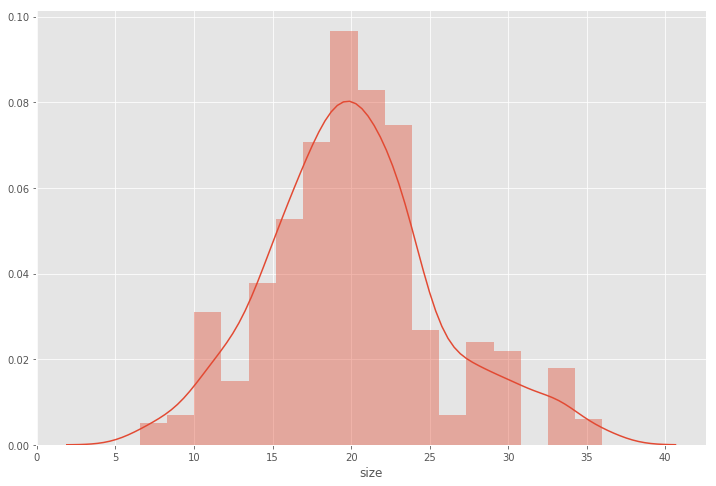

In [1081]:
plt.figure(figsize=(12, 8))
sns.distplot(df_4_new['size'])

In [1082]:
# df_4_newについて
df_4_new.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,579.000000,579.0,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,5.322280,4.0,20.196626,562.977520,7.204675,62.175214,21.203702,26.326558,18.118961,8.205231,184.278756,126.831813,57.447012
std,0.194752,0.0,5.540752,90.767345,1.056031,3.086654,0.944818,1.910062,0.836961,2.094808,13.373004,5.859029,14.659130
min,5.100000,4.0,6.553600,400.770000,5.850000,55.550000,20.301240,24.540000,11.560000,5.910000,171.800000,80.930000,41.400000
25%,5.200000,4.0,16.000000,503.050000,6.430000,61.000000,20.610000,25.860000,17.940000,7.290000,181.000000,125.600000,51.000000
50%,5.300000,4.0,19.448100,511.130000,7.170000,61.330000,20.980000,25.900000,18.110000,7.840000,181.300000,126.800000,54.900000
75%,5.400000,4.0,23.328900,637.670000,7.430000,65.030000,21.390000,26.340000,18.430000,8.200000,184.400000,129.000000,57.400000
max,6.000000,4.0,36.000000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [1083]:
# <-----------------------------------------------------------------------
# 4つのデータフレームを結合
df_new = pd.concat([df_1_new, df_2_new, df_3_new, df_4_new])

In [1084]:
#df_new = pd.concat([df_1, df_2, df_3, df_4])

In [1085]:
df_new['size'].size

2114

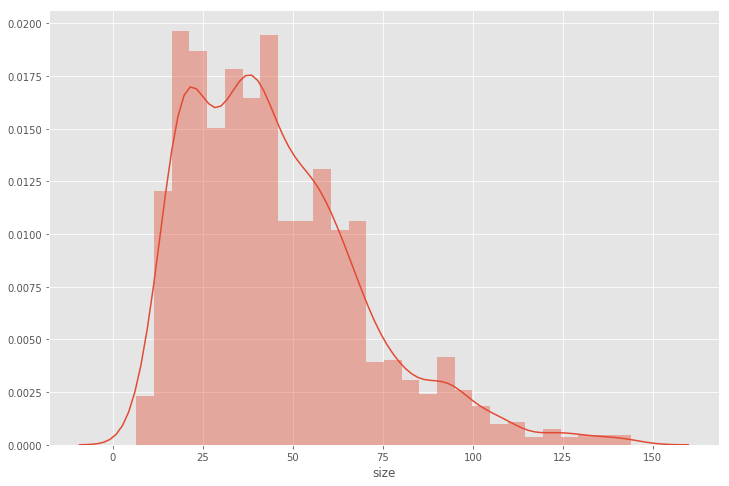

In [1086]:
plt.figure(figsize=(12, 8))
sns.distplot(df_new['size'])

In [1087]:
df_new.drop(['SumDiffTemp_7', 'AveMinTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'AveTemp_7', 'AveDiffTemp_7', 'AveHum_7'], axis=1, inplace=True) #対象の列を削除

In [1088]:
df_new.head(4)

,current_date,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveMaxTemp_7
2,11月28日,4.0,1,75.3424,614.28,6.17,26.24
3,11月28日,3.5,1,110.2500,614.28,6.17,26.24
36,12月4日,3.4,1,82.8100,589.90,6.07,25.13
40,12月4日,4.0,1,73.6164,589.90,6.07,25.13


In [1089]:
df_new.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df_new.shape)

(2114, 6)


In [1090]:
y = df_new["sweet_category"] #目的変数
df_new.drop(['sweet','sweet_category'], axis=1, inplace=True) #目的変数の列を削除
print(df_new.shape)

(2114, 4)


In [1091]:
#  <-----------------------------------------

#df_new['size_2'] = df_new['size']**2
#df_new['size_3'] = df_new['size']**3
#df_new['AveHum_7_2'] = df_new['AveHum_7']**2
#df_new['AveMaxTemp_7_2'] = df_new['AveMaxTemp_7']**2.5
#df_new['AveMinTemp_7_2'] = df_new['AveMinTemp_7']**2
#df_new['AveDiffTemp_7_2'] = df_new['AveDiffTemp_7']**2.5
#df_new['AveDiffTemp_7_3'] = df_new['AveDiffTemp_7']**3
#df_new['SumDiffTemp_7_2'] = df_new['SumDiffTemp_7']**2
df_new['AveSatu_7_3'] = df_new['AveSatu_7']**3
df_new['AveMaxTemp_7_3'] = df_new['AveMaxTemp_7']**3
#df_new['AveTemp_7_3'] = df_new['AveTemp_7']**3
#df_new['SumMinTemp_7_2'] = df_new['SumMinTemp_7']**2
#df_new['SumAveTemp_7_2'] = df_new['SumAveTemp_7']**2
df_new['AveCO2_7_1.5'] = df_new['AveCO2_7']**1.5

In [1092]:
df_new.drop(['AveCO2_7',  'AveMaxTemp_7', 'AveSatu_7'], axis=1, inplace=True) #対象の列を削除  

In [1093]:
df_new.head()

,size,AveSatu_7_3,AveMaxTemp_7_3,AveCO2_7_1.5
2,75.3424,234.885113,18067.226624,15224.728736
3,110.2500,234.885113,18067.226624,15224.728736
36,82.8100,223.648543,15870.019697,14327.406873
40,73.6164,223.648543,15870.019697,14327.406873
45,56.2500,223.648543,15870.019697,14327.406873


In [1094]:
# 訓練セットとテストセットに分割
#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=0)
#stratify は母集団のカテゴリの割合を保って分割するもので、目的変数を指定するのが一般的
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(df_new, y, test_size=0.3, random_state=1, stratify=y)

In [1095]:
# ハイパーパラメータ
params_grid = {'max_depth': [2,4,6,8,10,12], 'n_estimators': [50,100,200,1000]}

In [1096]:
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト

In [1097]:
grid_search = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax'), params_grid, scoring="accuracy",cv=10, n_jobs=-1)# 上記で用意したパラメーターごとに交差検証を実施

In [1098]:
grid_search.fit(X_trainval, y_trainval ) # 学習

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 4, 6, 8, 10, 12], 'n_estimators': [50, 100, 200, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [1099]:
# グリッドサーチの結果
print('Best cross-validation: {}'.format(round(grid_search.best_score_, 3)))
print('Best parameters : {}'.format(grid_search.best_params_))

Best cross-validation: 0.868
Best parameters : {'max_depth': 6, 'n_estimators': 100}


In [1100]:
print('Test set score : {}'.format(round(grid_search.score(X_test, y_test), 3)))

Test set score : 0.865


In [1101]:
# https://docs.google.com/document/d/1Ke9i88Wi6zBMIs36xYilp6JHD68RX8EZsNMD03imQno/edit
# 一番よかったのは、[aveTemp,aveCO2], [aveMaxTemp, aveHum]の2つで、訓練：テストでそれぞれ[74.4, 76.7], [75.0, 76.7]

In [1102]:
#多クラスの混合行列を作成

In [1103]:
from sklearn.metrics import confusion_matrix

In [1104]:
clf = grid_search.best_estimator_

In [1105]:
pred = clf.predict(X_test)

In [1106]:
print(confusion_matrix(y_test, pred))

[[ 63  11   0   0]
 [  5 139  23   0]
 [  0  19 189  12]
 [  0   0  16 158]]
